<a href="https://colab.research.google.com/github/evgeny-kolonsky/IMU/blob/main/pendulum/pendulum_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ колебаний маятника по данным IMU

Датчик **LSM6DS3** (6-DOF IMU) закреплён на маятнике. Плоскость колебаний — **X–Z**,
ось вращения — **Y**. Ось **Z** направлена вдоль силы тяжести в состоянии покоя.

Данные записаны автономным устройством XIAO Ball и переданы по BLE.

**Файлы:**
- `static.csv` — датчик в покое, для определения дрифта гироскопа и калибровки акселерометра
- `dynamic.csv` — свободные колебания маятника

**Известная величина:** ускорение свободного падения в точке эксперимента $g = 9{,}7949\ \text{м/с}^2$.

## 1. Модель  маятника


**Уравнение движения:**

$$\ddot{\theta} + \frac{g}{L}\sin\theta = 0$$

При малых углах ($\sin\theta \approx \theta$) решение гармоническое:

$$\theta(t) = A \sin(\omega t + \varphi_0)$$


**Угловая скорость** (измеряемая гироскопом):

$$\dot{\theta}(t) = A\omega\cos(\omega t + \varphi_0)$$

Пиковая угловая скорость $\dot{\theta}_{\max} = A\omega$, откуда **амплитуда**:

$$\boxed{A = \frac{\dot{\theta}_{\max}}{\omega}}$$



## 2. Загрузка библиотек и констант

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.fft import rfft, rfftfreq

plt.rcParams.update({
    'figure.figsize': (12, 4),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 11,
})

# Ускорение свободного падения в точке эксперимента (м/с²)
G_LOCAL = 9.7949

# Номинальное g, к которому привязана шкала датчика (стандарт ISO)
G_NOMINAL = 9.80665

## 3. Обработка статических данных — калибровка

Из записи в покое извлекаем:

1. **Дрифт гироскопа** $\boldsymbol{b}_\omega$ — среднее значение угловых скоростей.
   Вычитается из динамических данных.

2. **Нормировка акселерометра** — в покое $|\mathbf{a}|$ должен равняться $g$.
   Датчик отдаёт ускорение в единицах $g_{\text{ном}} = 9{,}80665$ м/с².
   Коэффициент нормировки $k_a = \dfrac{g_{\text{местн}}}{|\overline{\mathbf{a}}| \cdot g_{\text{ном}}}$
   переводит показания в истинные м/с² и компенсирует погрешность чувствительности.

In [17]:
url = 'https://raw.githubusercontent.com/evgeny-kolonsky/IMU/refs/heads/main/pendulum/'

static = np.genfromtxt(url+'static.csv', delimiter=',', skip_header=1)

t_s  = static[:, 0]
ax_s, ay_s, az_s = static[:, 1], static[:, 2], static[:, 3]
gx_s, gy_s, gz_s = static[:, 4], static[:, 5], static[:, 6]

print(f"Статическая запись: {len(t_s)} отсчётов, {t_s[-1]:.1f} с")
print()

# ── Дрифт гироскопа (°/с) ──
gyro_bias = np.array([np.mean(gx_s), np.mean(gy_s), np.mean(gz_s)])
print("Дрифт гироскопа (°/с):")
print(f"  bx = {gyro_bias[0]:+.4f}")
print(f"  by = {gyro_bias[1]:+.4f}")
print(f"  bz = {gyro_bias[2]:+.4f}")
print()

# ── Нормировка акселерометра ──
a_mean = np.array([np.mean(ax_s), np.mean(ay_s), np.mean(az_s)])
a_mag  = np.linalg.norm(a_mean)        # в единицах g_nominal
a_measured_ms2 = a_mag * G_NOMINAL      # в м/с²
k_accel = G_LOCAL / a_measured_ms2      # безразмерный поправочный множитель

print(f"Средний вектор в покое: ({a_mean[0]:.5f}, {a_mean[1]:.5f}, {a_mean[2]:.5f}) g_ном")
print(f"|a| (покой) = {a_mag:.6f} g_ном = {a_measured_ms2:.4f} м/с²")
print(f"Истинное g  = {G_LOCAL:.4f} м/с²")
print(f"Поправка k  = {k_accel:.6f}")

Статическая запись: 500 отсчётов, 5.0 с

Дрифт гироскопа (°/с):
  bx = +1.3257
  by = -2.9698
  bz = +0.4806

Средний вектор в покое: (0.03060, -0.03089, 1.04291) g_ном
|a| (покой) = 1.043818 g_ном = 10.2364 м/с²
Истинное g  = 9.7949 м/с²
Поправка k  = 0.956874


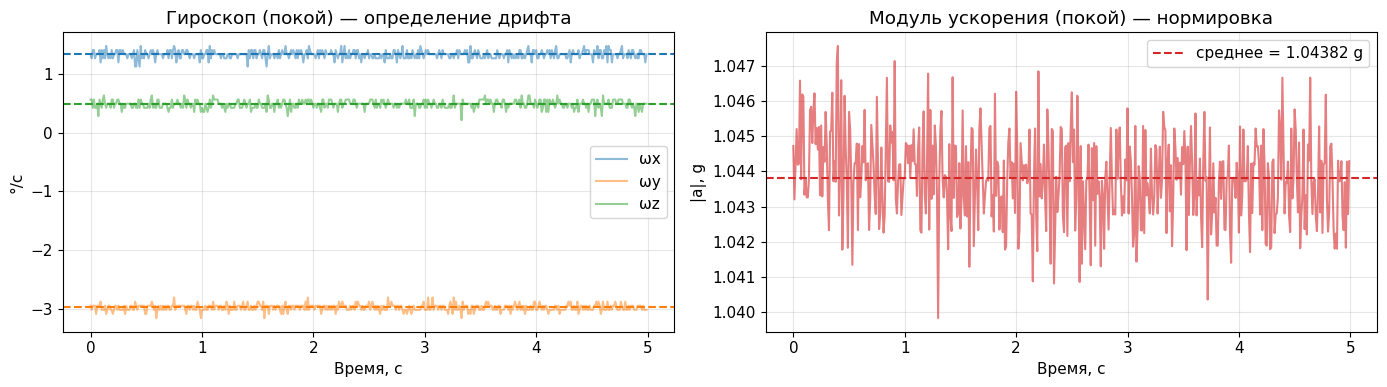

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(t_s, gx_s, alpha=0.5, label='ωx')
axes[0].plot(t_s, gy_s, alpha=0.5, label='ωy')
axes[0].plot(t_s, gz_s, alpha=0.5, label='ωz')
for b, c in zip(gyro_bias, ['C0','C1','C2']):
    axes[0].axhline(b, color=c, ls='--', lw=1.5)
axes[0].set_xlabel('Время, с'); axes[0].set_ylabel('°/с')
axes[0].set_title('Гироскоп (покой) — определение дрифта')
axes[0].legend()

a_total = np.sqrt(ax_s**2 + ay_s**2 + az_s**2)
axes[1].plot(t_s, a_total, color='C3', alpha=0.6)
axes[1].axhline(a_mag, color='C3', ls='--', lw=1.5, label=f'среднее = {a_mag:.5f} g')
axes[1].set_xlabel('Время, с'); axes[1].set_ylabel('|a|, g')
axes[1].set_title('Модуль ускорения (покой) — нормировка')
axes[1].legend()

plt.tight_layout(); plt.show()

## 4. Обработка динамических данных

Применяем калибровку:
- Вычитаем дрифт гироскопа: $\omega_i' = \omega_i - b_i$
- Нормируем ускорения: $a_i' = a_i \cdot k_a$

In [19]:
dyn = np.genfromtxt(url + 'dynamic.csv', delimiter=',', skip_header=1)

t  = dyn[:, 0]
ax = dyn[:, 1] * k_accel
ay = dyn[:, 2] * k_accel
az = dyn[:, 3] * k_accel
gx = dyn[:, 4] - gyro_bias[0]
gy = dyn[:, 5] - gyro_bias[1]
gz = dyn[:, 6] - gyro_bias[2]

print(f"Динамическая запись: {len(t)} отсчётов, {t[-1]:.1f} с")
print()
print("После калибровки (средние):")
print(f"  ax = {np.mean(ax):+.4f} g   ay = {np.mean(ay):+.4f} g   az = {np.mean(az):+.4f} g")
print(f"  ωx = {np.mean(gx):+.3f} °/с  ωy = {np.mean(gy):+.3f} °/с  ωz = {np.mean(gz):+.3f} °/с")
print(f"  |a| среднее = {np.mean(np.sqrt(ax**2 + ay**2 + az**2)):.4f} g")

Динамическая запись: 1000 отсчётов, 10.0 с

После калибровки (средние):
  ax = -0.0238 g   ay = +0.0084 g   az = +0.9988 g
  ωx = -0.049 °/с  ωy = -0.037 °/с  ωz = -0.004 °/с
  |a| среднее = 0.9992 g


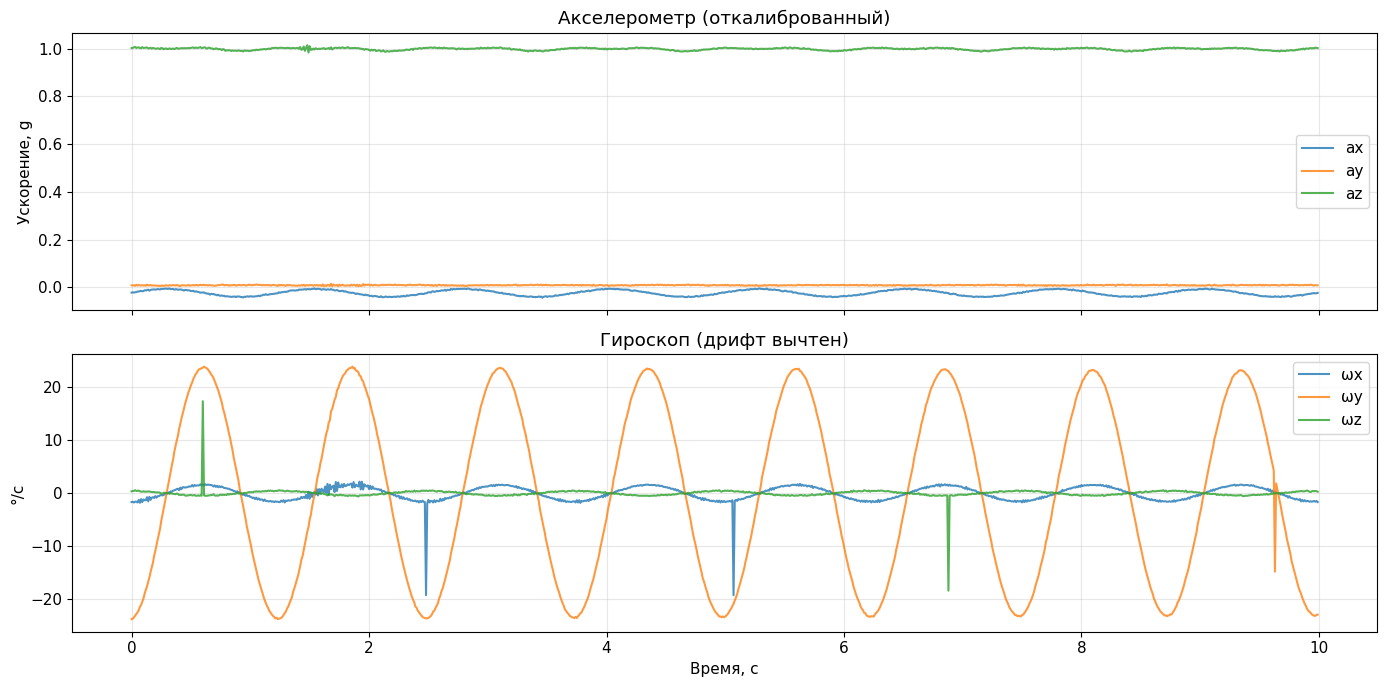

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)

axes[0].plot(t, ax, label='ax', alpha=0.8)
axes[0].plot(t, ay, label='ay', alpha=0.8)
axes[0].plot(t, az, label='az', alpha=0.8)
axes[0].set_ylabel('Ускорение, g')
axes[0].set_title('Акселерометр (откалиброванный)')
axes[0].legend()

axes[1].plot(t, gx, label='ωx', alpha=0.8)
axes[1].plot(t, gy, label='ωy', alpha=0.8)
axes[1].plot(t, gz, label='ωz', alpha=0.8)
axes[1].set_ylabel('°/с'); axes[1].set_xlabel('Время, с')
axes[1].set_title('Гироскоп (дрифт вычтен)')
axes[1].legend()

plt.tight_layout(); plt.show()

## 5. Определение периода колебаний

Ось вращения маятника — **Y**, поэтому основной сигнал — $\omega_y$.

Период определяем двумя способами:
1. **БПФ** — частотный пик
2. **Пики во временно́й области** — среднее расстояние между последовательными максимумами

=== Метод 1: БПФ ===
Доминантная частота: f = 0.8000 Гц
Период:             T = 1.2500 с


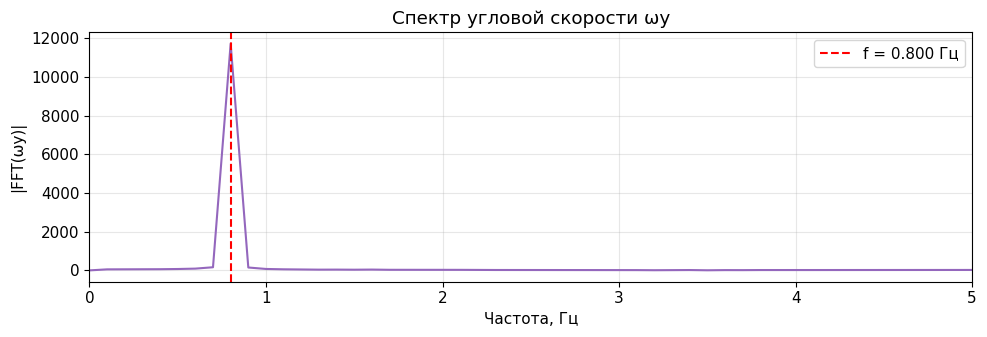

In [21]:
dt_avg = np.mean(np.diff(t))
N = len(gy)

# ── БПФ ──
spectrum = np.abs(rfft(gy))
freqs    = rfftfreq(N, dt_avg)
spectrum[0] = 0
f_peak = freqs[np.argmax(spectrum)]
T_fft  = 1.0 / f_peak

print("=== Метод 1: БПФ ===")
print(f"Доминантная частота: f = {f_peak:.4f} Гц")
print(f"Период:             T = {T_fft:.4f} с")

fig, ax = plt.subplots(figsize=(10, 3.5))
ax.plot(freqs, spectrum, color='C4')
ax.axvline(f_peak, color='red', ls='--', label=f'f = {f_peak:.3f} Гц')
ax.set_xlim(0, 5); ax.set_xlabel('Частота, Гц'); ax.set_ylabel('|FFT(ωy)|')
ax.set_title('Спектр угловой скорости ωy')
ax.legend(); plt.tight_layout(); plt.show()

In [22]:
# ── Пики во временно́й области ──
peaks_pos, _ = find_peaks( gy, distance=int(0.7 / dt_avg), prominence=5)
peaks_neg, _ = find_peaks(-gy, distance=int(0.7 / dt_avg), prominence=5)

periods_pos = np.diff(t[peaks_pos])
periods_neg = np.diff(t[peaks_neg])
all_periods = np.concatenate([periods_pos, periods_neg])

T_peaks = np.mean(all_periods)
T_std   = np.std(all_periods)

print("=== Метод 2: пики ===")
print(f"Положительных пиков: {len(peaks_pos)}")
print(f"Отрицательных пиков: {len(peaks_neg)}")
print(f"Период (среднее ± σ): T = {T_peaks:.4f} ± {T_std:.4f} с")
print()

T = T_peaks
omega = 2 * np.pi / T

print("═" * 40)
print(f"  Период:  T = {T:.4f} с")
print(f"  ω = 2π/T = {omega:.4f} рад/с")
print("═" * 40)

=== Метод 2: пики ===
Положительных пиков: 8
Отрицательных пиков: 7
Период (среднее ± σ): T = 1.2477 ± 0.0137 с

════════════════════════════════════════
  Период:  T = 1.2477 с
  ω = 2π/T = 5.0358 рад/с
════════════════════════════════════════


## 6. Амплитуда колебаний

Для гармонического маятника пиковая угловая скорость связана с амплитудой:

$$A = \frac{\dot\theta_{\max}}{\omega}$$

Находим $\dot\theta_{\max}$ из каждого полупериода, чтобы отследить затухание.

In [23]:
all_peaks = np.sort(np.concatenate([peaks_pos, peaks_neg]))
peak_gy   = np.abs(gy[all_peaks])
peak_t    = t[all_peaks]
amplitudes = peak_gy / omega

print("  №    Время, с    |ωy|, °/с    Амплитуда, °")
print("─" * 50)
for i, (tp, gp, ap) in enumerate(zip(peak_t, peak_gy, amplitudes)):
    print(f" {i+1:2d}      {tp:6.2f}       {gp:6.2f}         {ap:5.2f}")

A_mean = np.mean(amplitudes)

print()
print("═" * 40)
print(f"  Средняя амплитуда: A = {A_mean:.2f}°")
print(f"  Начальная:        A₀ = {amplitudes[0]:.2f}°")
print(f"  Конечная:         Aₙ = {amplitudes[-1]:.2f}°")
print("═" * 40)

  №    Время, с    |ωy|, °/с    Амплитуда, °
──────────────────────────────────────────────────
  1        0.61        23.90          4.75
  2        1.23        23.77          4.72
  3        1.86        23.90          4.75
  4        2.48        23.63          4.69
  5        3.10        23.69          4.70
  6        3.75        23.56          4.68
  7        4.34        23.55          4.68
  8        4.97        23.42          4.65
  9        5.59        23.48          4.66
 10        6.22        23.35          4.64
 11        6.85        23.41          4.65
 12        7.49        23.28          4.62
 13        8.09        23.27          4.62
 14        8.72        23.21          4.61
 15        9.34        23.20          4.61

════════════════════════════════════════
  Средняя амплитуда: A = 4.67°
  Начальная:        A₀ = 4.75°
  Конечная:         Aₙ = 4.61°
════════════════════════════════════════


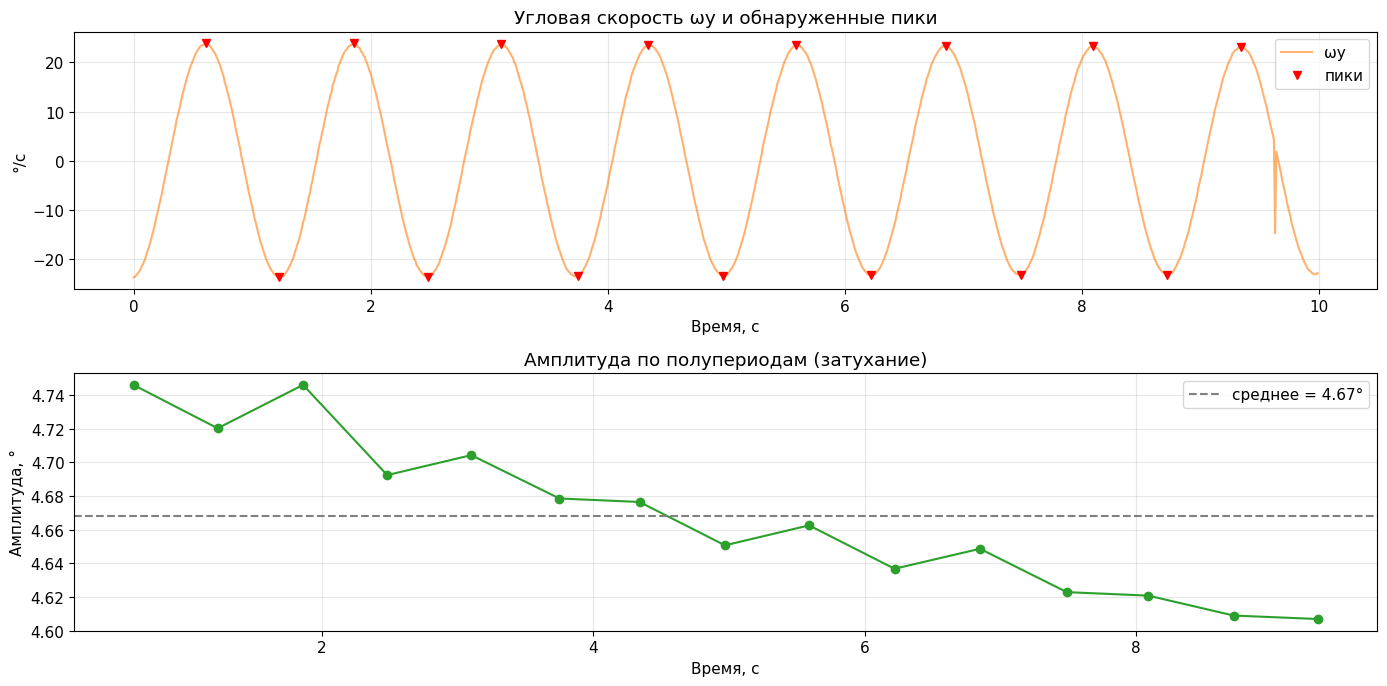

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7))

ax1.plot(t, gy, color='C1', alpha=0.6, label='ωy')
ax1.plot(peak_t, gy[all_peaks], 'rv', ms=6, label='пики')
ax1.set_xlabel('Время, с'); ax1.set_ylabel('°/с')
ax1.set_title('Угловая скорость ωy и обнаруженные пики')
ax1.legend()

ax2.plot(peak_t, amplitudes, 'o-', color='C2')
ax2.axhline(A_mean, ls='--', color='gray', label=f'среднее = {A_mean:.2f}°')
ax2.set_xlabel('Время, с'); ax2.set_ylabel('Амплитуда, °')
ax2.set_title('Амплитуда по полупериодам (затухание)')
ax2.legend()

plt.tight_layout(); plt.show()

## 7. Сводка результатов

In [25]:
print("┌──────────────────────────────────────────────────┐")
print("│           Результаты эксперимента                │")
print("├──────────────────────────────────────────────────┤")
print("│  g (местное)         {:>10.4f} м/с²            │".format(G_LOCAL))
print("│  Период T            {:>10.4f} с                │".format(T))
print("│  Частота f           {:>10.4f} Гц              │".format(1/T))
print("│  Амплитуда A         {:>10.2f}°                │".format(A_mean))
print("│  Дрифт ωy            {:>+10.4f} °/с            │".format(gyro_bias[1]))
print("│  Нормировка k_a      {:>10.6f}              │".format(k_accel))
print("└──────────────────────────────────────────────────┘")

┌──────────────────────────────────────────────────┐
│           Результаты эксперимента                │
├──────────────────────────────────────────────────┤
│  g (местное)             9.7949 м/с²            │
│  Период T                1.2477 с                │
│  Частота f               0.8015 Гц              │
│  Амплитуда A               4.67°                │
│  Дрифт ωy               -2.9698 °/с            │
│  Нормировка k_a        0.956874              │
└──────────────────────────────────────────────────┘
